# Features importance

Calculate the importance of each feature for each carbohydrate. Then, save a file located in `Result/feature_importances.xlsx` that contains the importances for all the features across all carbohydrates.

In [2]:
import os, random, sys
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap

import sklearn
from sklearn.ensemble import RandomForestClassifier

# Import custom libraries.
sys.path.append('Code/')
from dataset import load_and_preprocess, get_balance, downsampling, divide_dataset

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.facecolor'] = 'white'

In [7]:
X, y = load_and_preprocess()     # Dataset loading and preprocessing
y_OD = None                      # y for Outlier Detection
y_resampled = None               # y for Downsampling
resampled_dataframes = {}        # X resampled for each y_resampled

models = {
    'DT-FS': [[], [], [], [], [], [], []], # Decision Tree - Feature Selection
    'RF': [[], []],
}


threshold_rebalance = 0.4        # Under-sampling: 20%-40% or 60%-80% of majority class
threshold_OD = 0.2               # Outlier Detection: lower then 20% or greater than 80% of minority class
y_balanced = y.copy()

balancing = get_balance(X, y, draw=False, threshold_rebalance=threshold_rebalance, threshold_OD=threshold_OD)
y_balanced, y_od, y_resampled = divide_dataset(y_balanced, balancing, threshold_rebalance, threshold_OD)
resampled_dataframes = downsampling(X, y_resampled, threshold_rebalance, threshold_OD, draw=False)

Preprocessing...
  Null values of X:  0
  Null values of Y:  8 

  Columns of Y with null values:
    D-RIBose
    D-SACcharose (sucrose)
    potassium GlucoNaTe
    potassium 2-KetoGluconate
    potassium 5-KetoGluconate

Dataset loaded and preprocessed!


In [8]:
def train(X, y, params):
    
    feature_importance = {col: 0 for col in y.columns}
            
    for carbohydrate in y.columns:

        y_col = y[carbohydrate]
        n_estimators = params.loc[carbohydrate, 'Estimators']

        rfclf = RandomForestClassifier(n_estimators=n_estimators, max_depth=None, min_samples_split=2, random_state=1234, bootstrap=False)
        rfclf.fit(X, y_col)
        feature_importance[carbohydrate] = rfclf.feature_importances_        
        
    return feature_importance

In [10]:
feature_importance = None
feature_importance_balanced = None
feature_importance_resampled = None


# Normal training.
if os.path.exists('./Result/Performance/performance_classic.xlsx'):
    performance_classic = pd.read_excel('./Result/Performance/performance_classic.xlsx').set_index('Carbohydrates')
    
    feature_importance_balanced = train(X, y_balanced, performance_classic)
    feature_importance_balanced = pd.DataFrame(feature_importance_balanced).T
    feature_importance_balanced.columns = X.columns
else:
    print('Train firstly the models.')
    
    
# Training with resampled dataset.
if os.path.exists('./Result/Performance/performance_resampled.xlsx'):
    performance_resampled = pd.read_excel('./Result/Performance/performance_resampled.xlsx').set_index('Carbohydrates')

    for carbohydrate, df in resampled_dataframes.items():

        y_col = df[carbohydrate].to_frame()
        df = df.drop(carbohydrate, axis=1)

        tmp = train(df, y_col, performance_resampled)
        tmp = pd.DataFrame(tmp).T
        tmp.columns = X.columns
        feature_importance_resampled = pd.concat([feature_importance_resampled, tmp], axis=0)

        feature_importances = pd.concat([feature_importance_balanced, feature_importance_resampled], axis=0)

        with pd.ExcelWriter('./Result/feature_importances.xlsx') as writer:
            feature_importances.to_excel(writer, index=True)        
else:
    print('Train firstly the models.')

## Plots

Plot the importances of each feature.

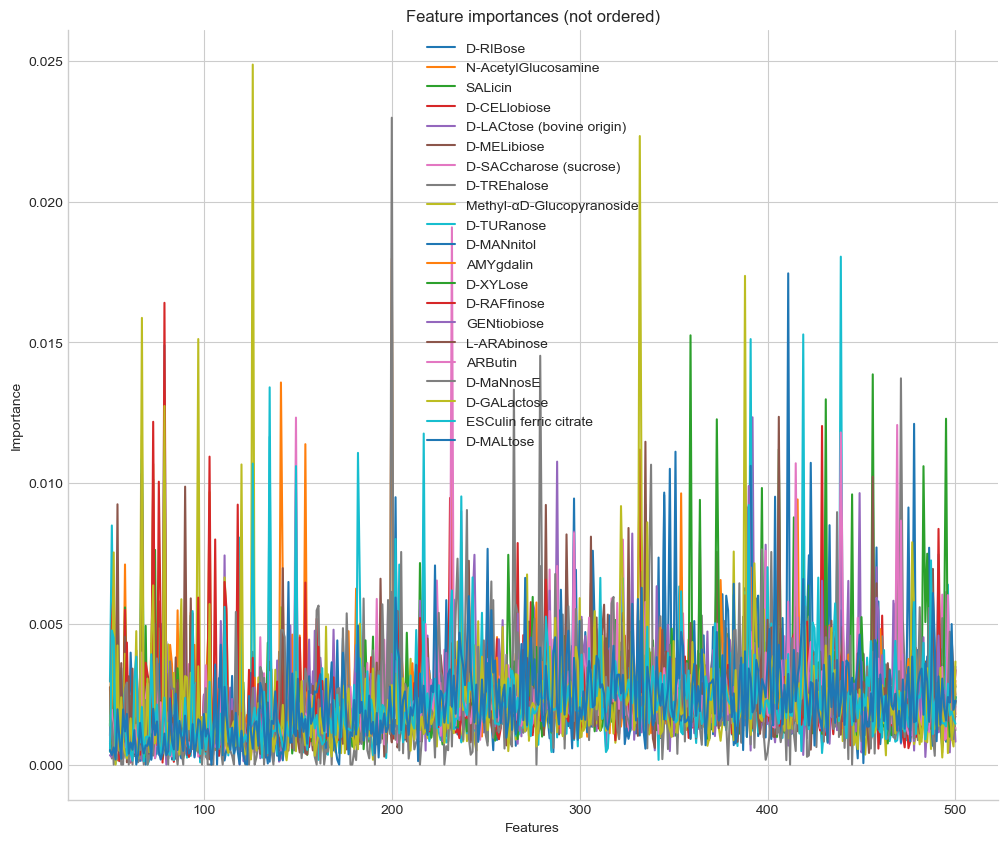

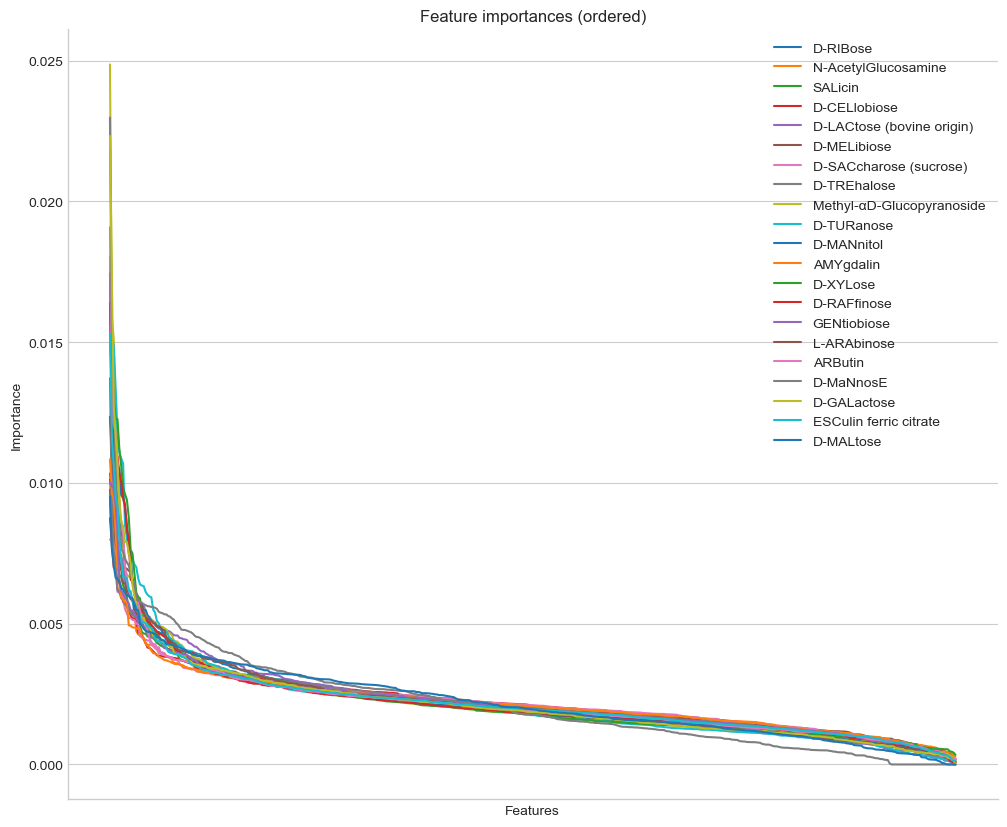

In [15]:
if os.path.exists('./Result/Performance/feature_importances.xlsx'):
    feature_importances = pd.read_excel('./Result/Performance/feature_importances.xlsx', index_col=0)
    feature_importances = feature_importances.rename_axis(['Carbohydrates'])

    
# Plot 1
plt.figure(figsize=(12, 10))

for idx, row in feature_importances.iterrows():
    plt.plot(feature_importances.columns, row, label=f'{row.name}')

plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature importances (not ordered)')
plt.legend()
plt.show()


# Plot 2
plt.figure(figsize=(12, 10))

for idx, row in feature_importances.iterrows():
    plt.plot(feature_importances.columns, row.sort_values(ascending=False), label=f'{row.name}')

plt.xlabel('Features')
plt.xticks([])
plt.ylabel('Importance')
plt.title('Feature importances (ordered)')
plt.legend()
plt.show()